<a href="https://colab.research.google.com/github/the-redlord/Image-super-resolution_keras/blob/master/Image_super-resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Super Resolution using Autoencoders in Keras

![image_high_res_low_res](images/high_res_v_low_res.jpg)

# Downloading Dataset

In [1]:
!wget -O dataset.zip 'https://d3c33hcgiwev3.cloudfront.net/2Pkn2dIvSzu5J9nSL_s77w_d428a2188ff44626be89908f348634e6_Completed_Notebook_Data_Autoencoders.zip?Expires=1593820800&Signature=U3pa2XSj1lnLKtAv7mALc8VLw1bnuCYqEi1qlByZCvCbPWPUPj8CKkA2oTOP47v22nTh7cFNXamXFN9xO1l0VSiyV4ZIRSu49mJxwmEklJDnCdi4vls0lPG~nLeUQ8g-~5VYc0aSzaeMPJYpQsRvDs2NPMw7hgzkYUb6tTvWqCU_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A'

--2020-07-03 11:33:59--  https://d3c33hcgiwev3.cloudfront.net/2Pkn2dIvSzu5J9nSL_s77w_d428a2188ff44626be89908f348634e6_Completed_Notebook_Data_Autoencoders.zip?Expires=1593820800&Signature=U3pa2XSj1lnLKtAv7mALc8VLw1bnuCYqEi1qlByZCvCbPWPUPj8CKkA2oTOP47v22nTh7cFNXamXFN9xO1l0VSiyV4ZIRSu49mJxwmEklJDnCdi4vls0lPG~nLeUQ8g-~5VYc0aSzaeMPJYpQsRvDs2NPMw7hgzkYUb6tTvWqCU_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A
Resolving d3c33hcgiwev3.cloudfront.net (d3c33hcgiwev3.cloudfront.net)... 13.224.227.70, 13.224.227.177, 13.224.227.42, ...
Connecting to d3c33hcgiwev3.cloudfront.net (d3c33hcgiwev3.cloudfront.net)|13.224.227.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1005471956 (959M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 958.89M  21.4MB/s    in 53s     

2020-07-03 11:34:53 (18.1 MB/s) - ‘dataset.zip’ saved [1005471956/1005471956]



In [ ]:
!unzip dataset.zip
!mkdir -p ./data
!mv ./Completed_Notebook_Data_Autoencoders/data/rez/cars_train ./data
!rm -rf ./Completed_Notebook_Data_Autoencoders

In [21]:
# download pre-trained weights

!wget https://github.com/the-redlord/Image-super-resolution_keras/raw/master/pre-trained/encoder_weights.hdf5
!wget https://github.com/the-redlord/Image-super-resolution_keras/raw/master/pre-trained/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5

--2020-07-03 12:56:10--  https://github.com/the-redlord/Image-super-resolution_keras/raw/master/pre-trained/encoder_weights.hdf5
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/the-redlord/Image-super-resolution_keras/master/pre-trained/encoder_weights.hdf5 [following]
--2020-07-03 12:56:10--  https://raw.githubusercontent.com/the-redlord/Image-super-resolution_keras/master/pre-trained/encoder_weights.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2252256 (2.1M) [application/octet-stream]
Saving to: ‘encoder_weights.hdf5’

encoder_weights.hdf 100%[===================>]   2.15M  --.-KB/s    in 0

## Task 1: Project Overview and Import Libraries

In [1]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
tf.debugging.set_log_device_placement(False)

## Task 2: What are Autoencoders?

![image3](images/autoencoder.jpg)

Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

![image_schema](images/complete_autoencoder.png)

## Task 3: Build the Encoder

In [20]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [21]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 128)     1475

## Task 4: Build the Decoder to Complete the Network

![image4](images/decoder.png)

In [22]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

In [23]:
l8 = UpSampling2D()(l7)
l9 = Conv2D(128,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l9)
l11 = add([l5,l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = add([l14,l2])
decoded = Conv2D(3,(3,3),padding='same',activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l15)

autoencoder = Model(input_img,decoded)

In [24]:
autoencoder.compile(optimizer='adadelta',loss='mean_squared_error')

In [25]:
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

## Task 5: Create Dataset and Specify Training Routine

In [77]:
def train_batches(just_load_dataset=False):

    batches = 256 

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("./data/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), (2.0,2.0,1.5)))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Task 6: Load the Dataset and Pre-trained Model

In [78]:
x_train_n,x_train_down = train_batches(just_load_dataset=True)

In [79]:
autoencoder.load_weights('/content/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

## Task 7: Model Predictions and Visualizing the Results

In [80]:
encoder.load_weights('/content/encoder_weights.hdf5')

In [81]:
encoded_imgs = encoder.predict(x_train_down)

In [82]:
encoded_imgs.shape

(256, 64, 64, 256)

In [83]:
# super resolution images
srl = np.clip(autoencoder.predict(x_train_down),0.0,1.0)

In [84]:
srl.shape

(256, 256, 256, 3)

In [85]:
image_index = 251

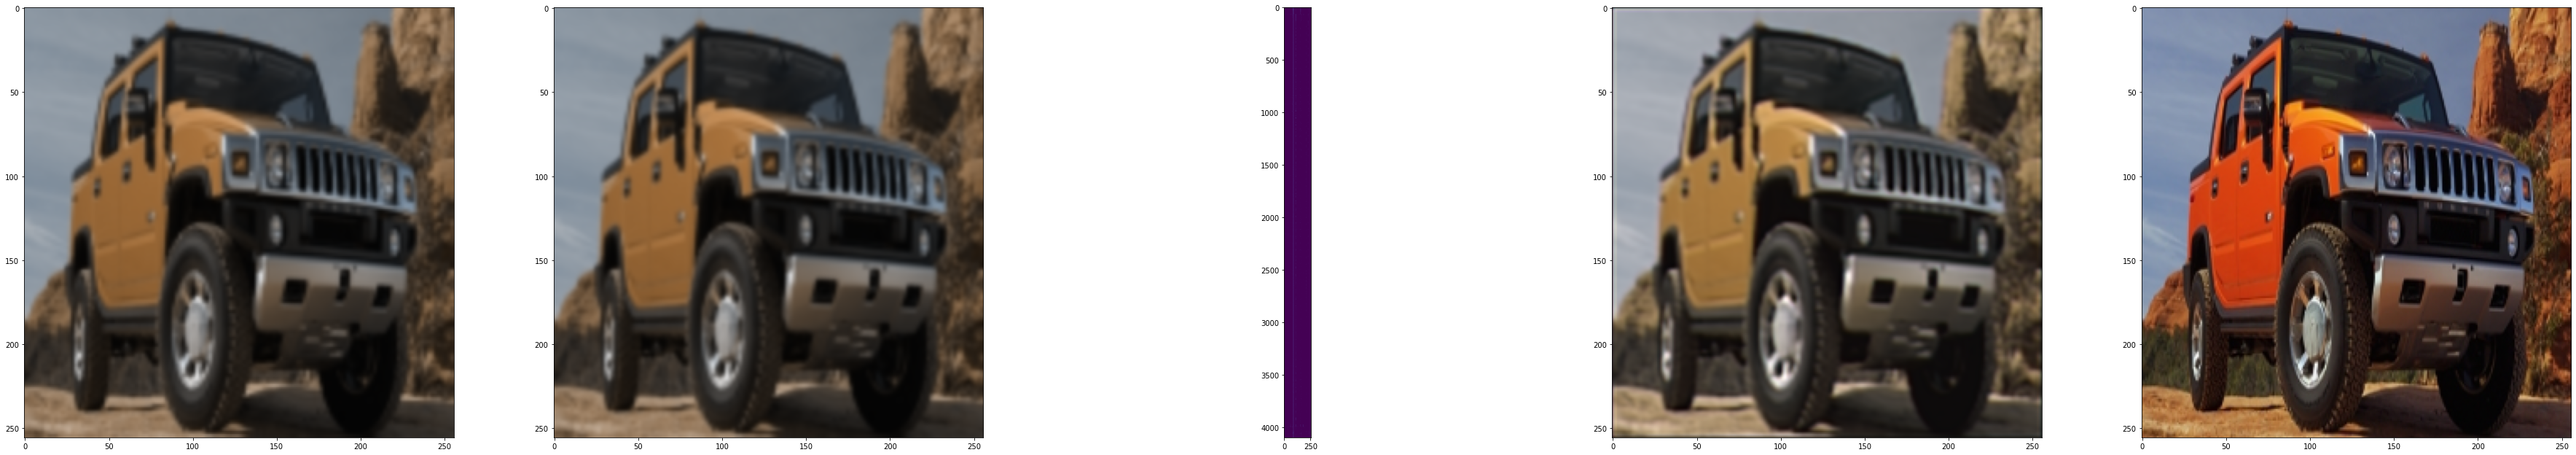

In [86]:
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])

i+=1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index],interpolation='bicubic')

i+=1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64,256)))

i+=1
ax = plt.subplot(10, 10, i)
plt.imshow(srl[image_index])

i+=1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()